### Data/Domain Understanding and Exploration

In [1]:
%matplotlib inline
import random
import numpy as np
from numpy import percentile
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
import xgboost as xgbo

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from xgboost import XGBRegressor

sns.set(rc={'figure.figsize': (8,6)}, style='ticks', context='talk', font_scale=0.8)
np.random.seed(22)
random.seed(22)

In [2]:
advert = pd.read_csv('adverts.csv')
advert.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


Feature Selection

In [3]:
advert.describe()

,public_reference,mileage,year_of_registration,price
count,4.020050e+05,401878.000000,368694.000000,4.020050e+05
mean,2.020071e+14,37743.595656,2015.006206,1.734197e+04
std,1.691662e+10,34831.724018,7.962667,4.643746e+04
min,2.013072e+14,0.000000,999.000000,1.200000e+02
25%,2.020090e+14,10481.000000,2013.000000,7.495000e+03
50%,2.020093e+14,28629.500000,2016.000000,1.260000e+04
75%,2.020102e+14,56875.750000,2018.000000,2.000000e+04
max,2.020110e+14,999999.000000,2020.000000,9.999999e+06


In [4]:
#checking the largest car prices
advert.nlargest(5, 'price')

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
141833,202007050883898,87450.0,NaN,Red,Ferrari,250,USED,NaN,9999999,Coupe,False,Petrol
147188,202009103539048,100.0,NaN,Grey,Maserati,3500,USED,NaN,9999999,Convertible,False,Petrol
252505,202008112331147,46300.0,NaN,Blue,Ferrari,275,USED,NaN,9999999,Coupe,False,Petrol
305436,201812223434109,3600.0,NaN,Grey,Lamborghini,Miura,USED,NaN,9999999,Coupe,False,Petrol
336202,202001226429470,950.0,NaN,Black,Ferrari,LaFerrari,USED,NaN,9999999,Coupe,False,Petrol


In [5]:
advert.info()
#a brief summary of the type of data and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [6]:
#showing the percentage of missing values in the data
na_percent = advert.isnull().sum() * 100 / len(advert)
na_percent 

public_reference         0.000000
mileage                  0.031592
reg_code                 7.924528
standard_colour          1.337794
standard_make            0.000000
standard_model           0.000000
vehicle_condition        0.000000
year_of_registration     8.286215
price                    0.000000
body_type                0.208206
crossover_car_and_van    0.000000
fuel_type                0.149501
dtype: float64

In [7]:
'''
here I am dropping all the missing values as they take less than 9% of the entire data and to also help my
data training and accuracy
'''
car = advert.dropna()
#car.dropna(subset=['mileage'], inplace=True)

In [8]:
car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363424 entries, 1 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       363424 non-null  int64  
 1   mileage                363424 non-null  float64
 2   reg_code               363424 non-null  object 
 3   standard_colour        363424 non-null  object 
 4   standard_make          363424 non-null  object 
 5   standard_model         363424 non-null  object 
 6   vehicle_condition      363424 non-null  object 
 7   year_of_registration   363424 non-null  float64
 8   price                  363424 non-null  int64  
 9   body_type              363424 non-null  object 
 10  crossover_car_and_van  363424 non-null  bool   
 11  fuel_type              363424 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 33.6+ MB


In [9]:
profile = ProfileReport(advert)
profile.to_file(output_file='cardataprofile.html')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
def data_distribution(col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].hist(col)
    ax[0].set_xlabel("Value")
    ax[0].set_ylabel("{col}")

    sns.boxplot(x=col, ax=ax[1])
    ax[1].set_xlabel("Value")
    ax[1].set_ylabel("")
    fig.suptitle('Data Distribution')
    plt.show()

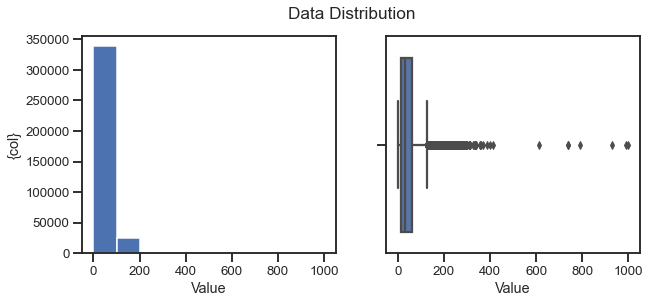

In [11]:
data_distribution(car['mileage']/1000)

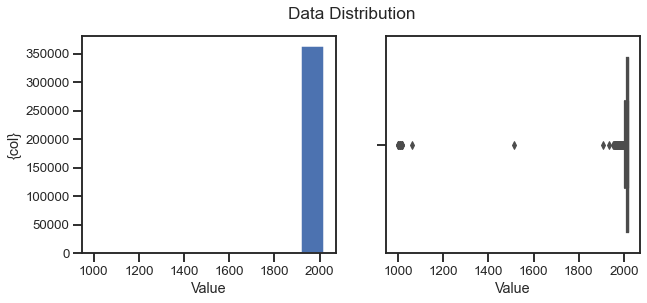

In [12]:
data_distribution(car['year_of_registration'])

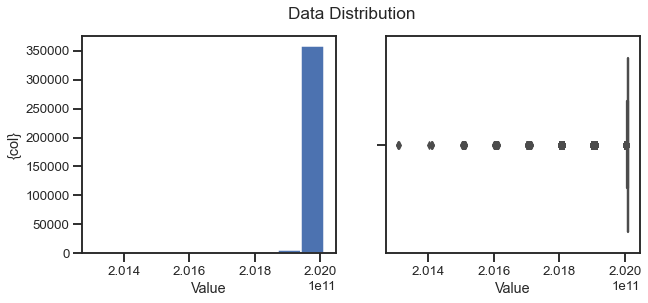

In [13]:
data_distribution(car['public_reference']/1000)

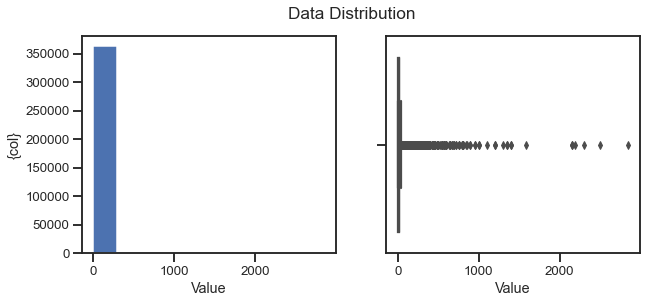

In [14]:
data_distribution(car['price']/1000)

<AxesSubplot:>

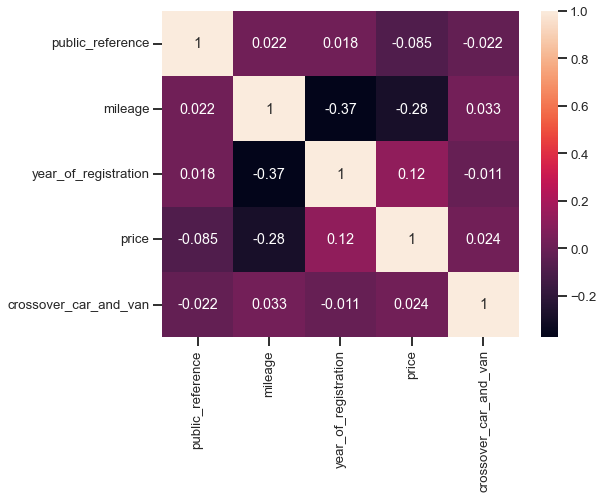

In [15]:
#using correlation analysis to show the predictive power of features
correlate = car.corr()
sns.heatmap(correlate, xticklabels=correlate.columns, yticklabels=correlate.columns, annot=True)

In [16]:
correlate
dfi.export(correlate, 'df_styled.png')

In [17]:
car['standard_make'].value_counts()

BMW               35277
Vauxhall          32227
Audi              32011
Volkswagen        30876
Mercedes-Benz     30037
                  ...  
Leyland               1
Carbodies             1
Ariel                 1
Wolseley              1
Custom Vehicle        1
Name: standard_make, Length: 103, dtype: int64

<AxesSubplot:xlabel='year_of_registration', ylabel='price'>

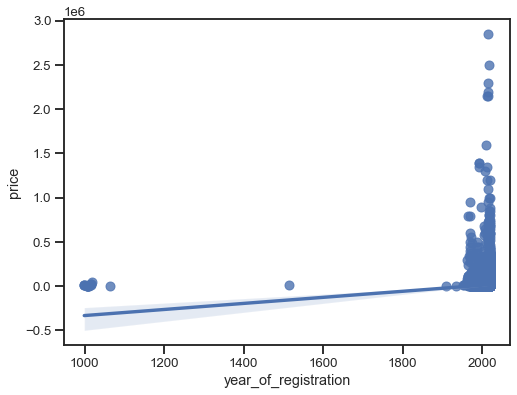

In [18]:
sns.regplot(data=car, x='year_of_registration', y='price')
#positive correlation with outliers

<AxesSubplot:xlabel='year_of_registration', ylabel='mileage'>

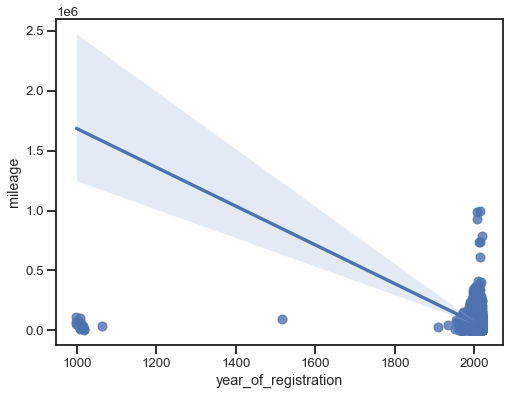

In [19]:
sns.regplot(data=car, x='year_of_registration', y='mileage')
#negative correlation with outliers

In [20]:
car[car.isnull().any(axis=1)]

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type


In [21]:
#sns.pairplot(car)

<AxesSubplot:xlabel='vehicle_condition', ylabel='price'>

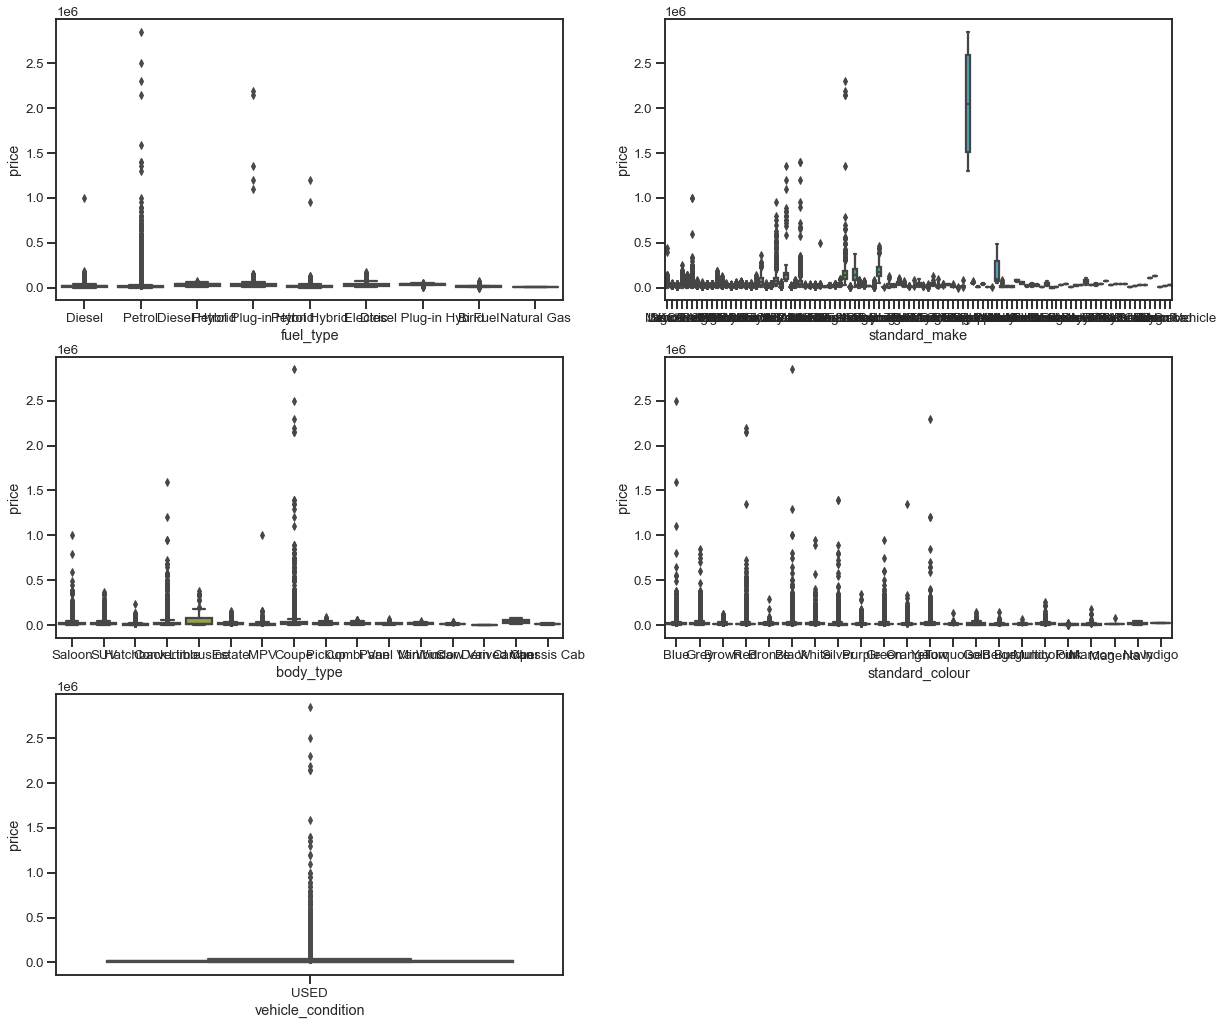

In [22]:
# Creating box plot for categorical variables

plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
sns.boxplot(x='fuel_type',y='price',data=car)
plt.subplot(5,2,2)
sns.boxplot(x='standard_make',y='price',data=car)
plt.subplot(5,2,3)
sns.boxplot(x='body_type',y='price',data=car)
plt.subplot(5,2,4)
sns.boxplot(x='standard_colour',y='price',data=car)
plt.subplot(5,2,5)
sns.boxplot(x='vehicle_condition',y='price',data=car)


### Data Processing for Machine Learning

In [23]:
def outlier_removal(col):
    Q25, Q50, Q75 = percentile(col,25), percentile(col, 50),percentile(col, 75)
    print('25th percentile:', Q25, '50th percentile: ', Q50, '75th percentile: ', Q75)
    IqR = Q75 - Q25
    #calculate cutoff outlier
    cutoff = IqR * 1.5
    lower_lim, upper_lim = Q25 - cutoff, Q75 + cutoff
    car[(col < lower_lim) | (col > upper_lim)]
    outliers = [i for i in col if i < lower_lim or i > upper_lim]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    car.drop(car[(col > upper_lim) | (col < lower_lim)].index, inplace=True)
    outliers_removed = [i for i in col if i >= lower_lim and i <= upper_lim]
    print('Non-outlier observations: %d' % len(outliers_removed))
    
    colx = col < upper_lim
    #data_distribution(col[colx])

In [24]:
x = ['mileage','year_of_registration', 'public_reference', 'price']
for i in x:
    print(i.upper())
    outlier_removal(car[i])
    print('-'*20)

MILEAGE
25th percentile: 14568.0 50th percentile:  31925.0 75th percentile:  60000.0
Identified outliers: 7337


C:\Users\RICHARD-OGUNDELE\AppData\Local\Temp\ipykernel_16844\4200987904.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car.drop(car[(col > upper_lim) | (col < lower_lim)].index, inplace=True)


Non-outlier observations: 356087
--------------------
YEAR_OF_REGISTRATION
25th percentile: 2014.0 50th percentile:  2016.0 75th percentile:  2018.0
Identified outliers: 19235
Non-outlier observations: 336852
--------------------
PUBLIC_REFERENCE
25th percentile: 202009033284271.75 50th percentile:  202009304410015.0 75th percentile:  202010175119758.5
Identified outliers: 41960
Non-outlier observations: 294892
--------------------
PRICE
25th percentile: 7890.0 50th percentile:  12250.0 75th percentile:  18500.0
Identified outliers: 17337
Non-outlier observations: 277555
--------------------


In [25]:
cat_cols = ['standard_colour','standard_make','body_type','reg_code']
enc = LabelEncoder()
car[cat_cols]=car[cat_cols].apply(enc.fit_transform)

C:\Users\RICHARD-OGUNDELE\AppData\Local\Temp\ipykernel_16844\260155985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car[cat_cols]=car[cat_cols].apply(enc.fit_transform)


In [26]:
#change categorical data in this column: crossover_car_and_van to int = LabelEncoder()
car['crossover_car_and_van'] = car['crossover_car_and_van'].map({False:0, True:1})

C:\Users\RICHARD-OGUNDELE\AppData\Local\Temp\ipykernel_16844\3457342095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car['crossover_car_and_van'] = car['crossover_car_and_van'].map({False:0, True:1})


In [27]:
#change categorical data in this columns to integers and replaces used with 0 and new with 1
car['vehicle_condition'] = car['vehicle_condition'].map({"USED":0, "NEW":1})

C:\Users\RICHARD-OGUNDELE\AppData\Local\Temp\ipykernel_16844\1009655302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car['vehicle_condition'] = car['vehicle_condition'].map({"USED":0, "NEW":1})


In [29]:
car = pd.get_dummies(car, columns=['fuel_type']) 

In [30]:
car['reg_code'].unique()

array([14, 10,  5, 33, 16, 13, 30,  9, 15, 29, 25, 28,  6, 12, 17, 11,  7,
       31, 26, 34,  8, 23, 22, 32, 27, 24, 21,  3, 19, 40, 20,  2, 36,  0,
       38,  1, 18, 35,  4, 37, 41, 39])

### Model Building

In [31]:
car.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type_Bi Fuel,fuel_type_Diesel,fuel_type_Diesel Hybrid,fuel_type_Diesel Plug-in Hybrid,fuel_type_Electric,fuel_type_Petrol,fuel_type_Petrol Hybrid,fuel_type_Petrol Plug-in Hybrid
5,202009304412074,16000.0,14,2,3,S5,0,2017.0,29000,3,0,0,0,0,0,0,1,0,0
7,202009244143980,99000.0,10,3,27,Range Rover,0,2013.0,24475,12,0,0,1,0,0,0,0,0,0
8,202010014442611,111236.0,5,1,36,S Class,0,2008.0,6995,7,0,0,1,0,0,0,0,0,0
12,202009173867934,4765.0,33,20,48,Octavia,0,2019.0,16990,5,0,0,0,0,0,0,1,0,0
13,202009234108830,18214.0,16,18,47,Leon,0,2019.0,14290,6,0,0,0,0,0,0,1,0,0


In [32]:
X = car.drop(labels=['public_reference','price', 'standard_model'],axis=1)
y= car['price']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((222044, 16), (55511, 16), (222044,), (55511,))

In [35]:
dtr = DecisionTreeRegressor(max_depth=6, min_samples_leaf=8, min_samples_split=10, random_state=42)
xgb = XGBRegressor(objective ='reg:squarederror',max_depth = 24, alpha = 5, n_estimators = 200, random_state = 42)
rfr = RandomForestRegressor(n_estimators=50,max_depth=3, min_samples_leaf=3)

In [36]:
#Using the Random Forest Regressor
rfr.fit(X_train,y_train)
ry_pred = rfr.predict(X_test)
# metrics for random forest
rtrain_score = rfr.score(X_train, y_train)
r2score = r2_score(y_test, ry_pred)
r_mae = mean_absolute_error(y_test, ry_pred)
r_mse = mean_squared_error(y_test, ry_pred)
r_rmse = np.sqrt(r_mse)            

In [37]:
#Using the XGBRegressor Model
xgb.fit(X_train,y_train)
y_predx = xgb.predict(X_test)

# metrics for XGBRegressor
xtrain_score = xgb.score(X_train, y_train)
x_r2score = r2_score(y_test, y_predx)
x_mae = mean_absolute_error(y_test, y_predx)
x_mse = mean_squared_error(y_test, y_predx)
x_rmse = np.sqrt(x_mse)            

In [38]:
dtr.fit(X_train, y_train)
dy_pred =  dtr.predict(X_test)
# metrics for decision Tree
dtrain_score = dtr.score(X_train, y_train)
d_r2score = r2_score(y_test, dy_pred)
d_mae = mean_absolute_error(y_test, dy_pred)
d_mse = mean_squared_error(y_test, dy_pred)
d_rmse = np.sqrt(d_mse)            

In [39]:
metric = {'Train Score':[xtrain_score,dtrain_score,rtrain_score], 'R2_score':[x_r2score,d_r2score,r2score],
       'MAE':[x_mae,d_mae,r_mae], 'MSE':[x_mse,d_mse,r_mse], 'RMSE':[x_rmse,d_mse,r_mse]}

met=pd.DataFrame(metric, index=['XGBoostRegressor','DecisionTreeRegressor','RandomForestRegressor'])
print(met)

                       Train Score  R2_score          MAE           MSE  \
XGBoostRegressor          0.996026  0.804572  2101.367496  9.866475e+06   
DecisionTreeRegressor     0.667767  0.666507  3005.121910  1.683688e+07   
RandomForestRegressor     0.456466  0.456853  3968.847622  2.742153e+07   

                               RMSE  
XGBoostRegressor       3.141095e+03  
DecisionTreeRegressor  1.683688e+07  
RandomForestRegressor  2.742153e+07  


In [40]:
dfi.export(met, 'metrics.png')

In [41]:
param_grid = {
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    "reg_alpha": [0, 0.5, 1, 5],
    'max_depth': [ 2, 4, 6,],
}
grid = GridSearchCV(XGBRegressor(),  param_grid, cv=3,
    scoring='neg_root_mean_squared_error', return_train_score=True)

In [42]:
#grid.fit(X_train, y_train)

In [ ]:
print(f'The best score is {grid.best_score_:.4f}')
print('The best score standard deviation is', round(grid.cv_results_['std_test_recall'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid.best_params_}')

### Model Evaluation and Analysis 

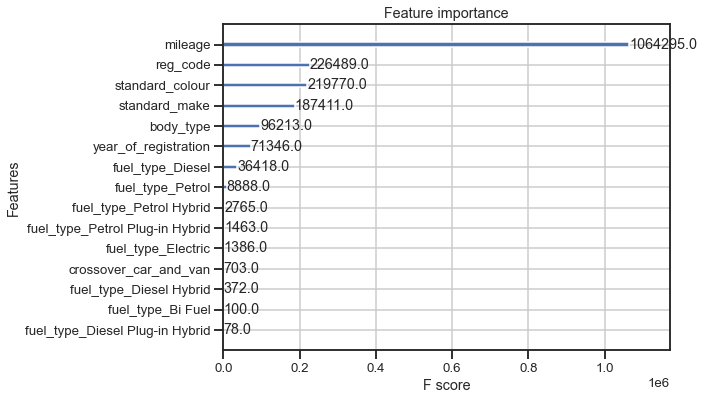

In [44]:
xgbo.plot_importance(xgb)
plt.rcParams['figure.figsize'] = [10,10]
plt.savefig('XGBoost-Features-Importance.jpg')
plt.show();

In [45]:
y_true = y_test

y_predx - y_true

63589    -4305.314453
379011    1361.259766
128478    -141.402344
314906     -31.497070
210186     224.215820
             ...     
244175     274.505859
233549   -5084.765625
379112    -267.839844
120321      18.756836
159584     623.732422
Name: price, Length: 55511, dtype: float64

In [46]:
residual = rfr.predict(X) - y
residual = pd.Series(residual).rename('residual')
residual.head()

5    -12617.449619
7    -11262.115327
8     -1994.855938
12      909.164138
13     3609.164138
Name: residual, dtype: float64

In [47]:
residual_abs = residual.abs().rename('residual_abs')
X_res = pd.concat([ X, residual, residual_abs ], axis='columns')
X_res.sort_values('residual_abs', ascending=False)

,mileage,reg_code,standard_colour,standard_make,vehicle_condition,year_of_registration,body_type,crossover_car_and_van,fuel_type_Bi Fuel,fuel_type_Diesel,fuel_type_Diesel Hybrid,fuel_type_Diesel Plug-in Hybrid,fuel_type_Electric,fuel_type_Petrol,fuel_type_Petrol Hybrid,fuel_type_Petrol Plug-in Hybrid,residual,residual_abs
180254,79346.0,6,1,43,0,2009.0,3,0,0,0,0,0,0,1,0,0,-28999.855938,28999.855938
158777,36000.0,5,1,5,0,2008.0,3,0,0,0,0,0,0,1,0,0,-28999.855938,28999.855938
3384,47500.0,6,18,39,0,2009.0,4,0,0,0,0,0,0,1,0,0,-28998.855938,28998.855938
338675,40000.0,21,1,43,0,2008.0,3,0,0,0,0,0,0,1,0,0,-28994.855938,28994.855938
52018,55000.0,6,1,39,0,2009.0,4,0,0,0,0,0,0,1,0,0,-28994.855938,28994.855938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389127,80000.0,7,7,33,0,2010.0,6,0,0,0,0,0,0,1,0,0,0.144062,0.144062
233677,13000.0,26,18,47,0,2012.0,6,0,0,0,0,0,0,1,0,0,0.144062,0.144062
265873,99987.0,23,1,4,0,2009.0,6,0,0,0,0,0,0,1,0,0,0.144062,0.144062
385632,73929.0,25,1,4,0,2011.0,6,0,0,0,0,0,0,1,0,0,0.144062,0.144062


In [48]:
car_res = pd.concat([ car, residual, residual_abs ], axis='columns')
car_res.sort_values('residual_abs', ascending=False).head(20)

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,...,fuel_type_Bi Fuel,fuel_type_Diesel,fuel_type_Diesel Hybrid,fuel_type_Diesel Plug-in Hybrid,fuel_type_Electric,fuel_type_Petrol,fuel_type_Petrol Hybrid,fuel_type_Petrol Plug-in Hybrid,residual,residual_abs
180254,202009193945760,79346.0,6,1,43,911,0,2009.0,34000,3,...,0,0,0,0,0,1,0,0,-28999.855938,28999.855938
158777,202009183896507,36000.0,5,1,5,Continental,0,2008.0,34000,3,...,0,0,0,0,0,1,0,0,-28999.855938,28999.855938
3384,202010305599502,47500.0,6,18,39,GT-R,0,2009.0,33999,4,...,0,0,0,0,0,1,0,0,-28998.855938,28998.855938
338675,202010064660295,40000.0,21,1,43,911,0,2008.0,33995,3,...,0,0,0,0,0,1,0,0,-28994.855938,28994.855938
52018,202010305630811,55000.0,6,1,39,GT-R,0,2009.0,33995,4,...,0,0,0,0,0,1,0,0,-28994.855938,28994.855938
365900,202009304406342,63500.0,22,1,2,DB9,0,2008.0,33995,4,...,0,0,0,0,0,1,0,0,-28994.855938,28994.855938
308453,202010205211711,16000.0,8,1,31,Evora,0,2011.0,33995,4,...,0,0,0,0,0,1,0,0,-28994.855938,28994.855938
309411,202010165079929,50000.0,6,17,39,GT-R,0,2009.0,33995,4,...,0,0,0,0,0,1,0,0,-28994.855938,28994.855938
151937,202009163807702,59000.0,23,20,43,911,0,2009.0,33995,3,...,0,0,0,0,0,1,0,0,-28994.855938,28994.855938
237041,202011015677357,47677.0,9,1,43,Panamera,0,2012.0,33995,6,...,0,0,0,0,0,1,0,0,-28994.855938,28994.855938
